# Federated Learning on Non-IID Mild Dataset

This notebook evaluates the federated learning pipeline under **moderate data heterogeneity** using the `non_iid_mild` data profile.

## Purpose

The `non_iid_mild` profile represents **realistic industrial heterogeneity**:
- More challenging than IID (`clean`) but less extreme than `non_iid_hard`
- Tests how well FL handles moderate non-IID conditions
- Provides performance benchmarks between the two extremes

## ⚠️ Important: No Training Logic Changes

**All training logic remains UNCHANGED.** This notebook only:
- Uses public APIs and configuration switches
- Sets `data_profile="non_iid_mild"` as the **only experimental difference**

The following components are **NOT modified**:
- Training loops
- Model architecture (TCN)
- Aggregation logic (FedAvg)
- Evaluation metrics
- Logging
- Random seed handling

---

## Non-IID Mild Profile Characteristics

| Dimension | Description |
|-----------|-------------|
| **Label Skew** | Overlapping but shifted RUL ranges per client |
| **Feature Skew** | Moderate client-specific noise ∈ [0.05, 0.2], bias ∈ [-1, +1] |
| **Quantity Skew** | Imbalanced sizes: [400, 300, 250, 200, 150] |
| **Concept Drift** | None (temporal consistency) |

## 1. Imports & Setup

In [9]:
import sys
from pathlib import Path
import warnings
import importlib

# Robust project root detection
def find_project_root(start_path: Path = None, markers: tuple = ("pyproject.toml", ".git", "src")):
    """Search upward from start_path for a directory containing any of the markers."""
    path = (start_path or Path.cwd()).resolve()
    for parent in [path] + list(path.parents):
        if any((parent / marker).exists() for marker in markers):
            return parent
    return path

project_root = find_project_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Force reload modules to pick up latest changes
import src.data.non_iid_generator
import experiments.federated_matrix
importlib.reload(src.data.non_iid_generator)
importlib.reload(experiments.federated_matrix)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Standard imports
import numpy as np
import pandas as pd
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Experiment framework - NO custom models or training loops!
from experiments.federated_matrix import (
    FederatedExperimentConfig,
    FederatedExperiment,
)

print("✅ Imports successful!")
print(f"📁 Project root: {project_root}")

✅ Imports successful!
📁 Project root: C:\Users\Atharva Srivastava\Downloads\fedind


## 2. Experiment Configuration

**Key point**: The **only change** from clean/hard experiments is `data_profile="non_iid_mild"`.

This guarantees:
- **Experimental fairness**: Same model, hyperparameters, and evaluation
- **Reproducibility**: Fixed seed ensures consistent results

In [10]:
# Configure the experiment
config = FederatedExperimentConfig(
    # ========================================
    # THE ONLY CHANGE FROM OTHER EXPERIMENTS
    # ========================================
    data_profile="non_iid_mild",
    
    # Experiment identification
    experiment_id="non_iid_mild_evaluation",
    experiment_name="FL Non-IID Mild Benchmark",
    
    # Client settings
    num_clients=5,
    heterogeneity_mode="uniform",  # Forced to uniform when data_profile="non_iid_mild"
    
    # Task settings
    task="rul",
    
    # Federated learning settings
    num_rounds=15,
    participation_fraction=1.0,  # All clients participate each round
    local_epochs=3,
    batch_size=32,
    lr=1e-3,
    
    # Model architecture (UNCHANGED from clean)
    num_layers=4,
    hidden_dim=64,
    kernel_size=3,
    dropout=0.2,
    fc_hidden=32,
    
    # Evaluation
    eval_every=1,  # Evaluate every round for detailed tracking
    
    # Reproducibility
    seed=42,
    deterministic=True,
    
    # Output
    output_dir="experiments/outputs/non_iid_mild_evaluation",
    save_checkpoints=True,
)

print("="*60)
print("EXPERIMENT CONFIGURATION")
print("="*60)
print(f"  Data Profile:        {config.data_profile} ⬅️ THE ONLY CHANGE")
print(f"  Num Clients:         {config.num_clients}")
print(f"  Num Rounds:          {config.num_rounds}")
print(f"  Local Epochs:        {config.local_epochs}")
print(f"  Participation:       {config.participation_fraction:.0%}")
print(f"  Batch Size:          {config.batch_size}")
print(f"  Learning Rate:       {config.lr}")
print(f"  Seed:                {config.seed}")
print("="*60)

EXPERIMENT CONFIGURATION
  Data Profile:        non_iid_mild ⬅️ THE ONLY CHANGE
  Num Clients:         5
  Num Rounds:          15
  Local Epochs:        3
  Participation:       100%
  Batch Size:          32
  Learning Rate:       0.001
  Seed:                42


## 3. Data Sanity Check (Validation Only)

⚠️ **This section is for validation and explanation only.** The data is NOT used for training - the `FederatedExperiment` class handles all data generation internally.

This visualization demonstrates the moderate heterogeneity of the mild profile.

In [3]:
from src.data.non_iid_generator import (
    generate_non_iid_mild_data,
    get_mild_data_profile_stats,
    MILD_CLIENT_NOISE,
    MILD_CLIENT_BIAS,
    MILD_CLIENT_DATA_SIZES,
    MILD_CLIENT_RUL_RANGES,
)

# Generate sample data for visualization (NOT used for training)
NUM_CLIENTS = config.num_clients
SEED = config.seed

sample_partitions = generate_non_iid_mild_data(
    num_clients=NUM_CLIENTS,
    seq_length=100,
    num_channels=14,
    task="rul",
    seed=SEED,
)

# Print profile configuration
print("="*60)
print("NON-IID MILD PROFILE CONFIGURATION")
print("="*60)
print(f"\n📊 Client RUL Ranges (Overlapping):")
for client_id, (rul_min, rul_max) in MILD_CLIENT_RUL_RANGES.items():
    print(f"   Client {client_id}: RUL ∈ [{rul_min}, {rul_max}]")

print(f"\n🔊 Feature Skew:")
for client_id in range(NUM_CLIENTS):
    print(f"   Client {client_id}: noise={MILD_CLIENT_NOISE[client_id]}, bias={MILD_CLIENT_BIAS[client_id]}")

print(f"\n📈 Quantity Skew:")
for client_id, size in MILD_CLIENT_DATA_SIZES.items():
    X_c, y_c = sample_partitions[client_id]
    print(f"   Client {client_id}: {len(X_c)} samples (target: {size})")

NON-IID MILD PROFILE CONFIGURATION

📊 Client RUL Ranges (Overlapping):
   Client 0: RUL ∈ [0, 70]
   Client 1: RUL ∈ [20, 90]
   Client 2: RUL ∈ [10, 80]
   Client 3: RUL ∈ [0, 100]
   Client 4: RUL ∈ [30, 100]

🔊 Feature Skew:
   Client 0: noise=0.05, bias=0.0
   Client 1: noise=0.15, bias=0.5
   Client 2: noise=0.1, bias=-0.5
   Client 3: noise=0.2, bias=1.0
   Client 4: noise=0.08, bias=-1.0

📈 Quantity Skew:
   Client 0: 400 samples (target: 400)
   Client 1: 300 samples (target: 300)
   Client 2: 250 samples (target: 250)
   Client 3: 200 samples (target: 200)
   Client 4: 150 samples (target: 150)


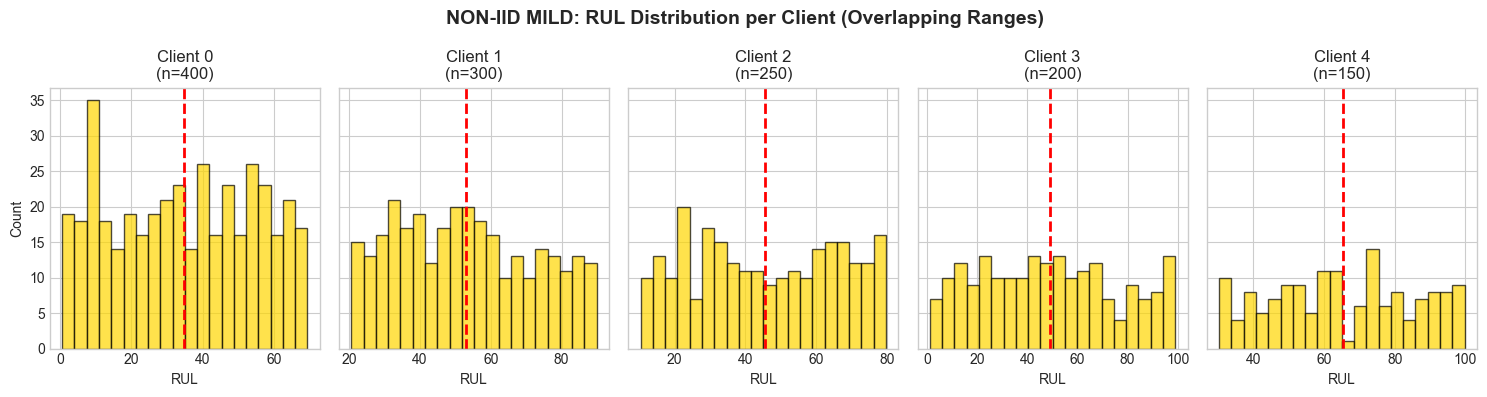


📊 RUL Statistics per Client:
   Client 0: mean=34.8, std=19.9, range=[1, 69]
   Client 1: mean=53.1, std=19.2, range=[21, 90]
   Client 2: mean=45.6, std=20.4, range=[10, 80]
   Client 3: mean=49.0, std=27.3, range=[1, 99]
   Client 4: mean=65.3, std=20.2, range=[30, 100]


In [4]:
# Visualize RUL distributions per client
fig, axes = plt.subplots(1, NUM_CLIENTS, figsize=(15, 4), sharey=True)

for i, (X_c, y_c) in enumerate(sample_partitions):
    axes[i].hist(y_c, bins=20, alpha=0.7, color='gold', edgecolor='black')
    axes[i].axvline(y_c.mean(), color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'Client {i}\n(n={len(y_c)})')
    axes[i].set_xlabel('RUL')
    if i == 0:
        axes[i].set_ylabel('Count')

fig.suptitle('NON-IID MILD: RUL Distribution per Client (Overlapping Ranges)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary stats
print("\n📊 RUL Statistics per Client:")
for i, (X_c, y_c) in enumerate(sample_partitions):
    print(f"   Client {i}: mean={y_c.mean():.1f}, std={y_c.std():.1f}, range=[{y_c.min():.0f}, {y_c.max():.0f}]")

## 4. Run Federated Learning Experiment

This section runs the actual FL experiment using the same training infrastructure as clean/hard experiments.

In [11]:
# Create and run experiment
print("="*60)
print("RUNNING FEDERATED LEARNING WITH NON-IID MILD DATA")
print("="*60)

experiment = FederatedExperiment(config)
results = experiment.run()

print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)

2026-01-17 20:34:42,440 [INFO] Using NON-IID MILD data profile
2026-01-17 20:34:42,441 [INFO]   - Label skew: overlapping RUL distributions
2026-01-17 20:34:42,442 [INFO]   - Feature skew: moderate noise/bias
2026-01-17 20:34:42,443 [INFO]   - Quantity skew: moderate imbalance


RUNNING FEDERATED LEARNING WITH NON-IID MILD DATA


2026-01-17 20:34:42,925 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 20:34:42,933 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 20:34:42,934 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 20:34:42,936 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 20:34:42,937 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 20:34:42,938 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 20:34:42,939 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 20:34:42,981 [INFO] ============================================================
2026-01-17 20:34:42,982 [INFO] Starting Federated Training: non_iid_mild_evaluation
2026-01-17 20:34:42,983 [INFO]   Algorithm: FEDAVG
2026-01-17 20:34:42,984 [INFO]   Rounds: 15
2026-01-17 20:34:42,984 [INFO]   Clients: 5
2026-01-17 20:34:42,986 [INFO]   Participation: 100%
2026-01-17 20:34:42,987 [INFO]   Local epochs: 3
2026-01-17 20:34:42,988 [INFO]   Heterogeneity: uniform
2026-01-17 20:


EXPERIMENT COMPLETE


## 5. Results Analysis

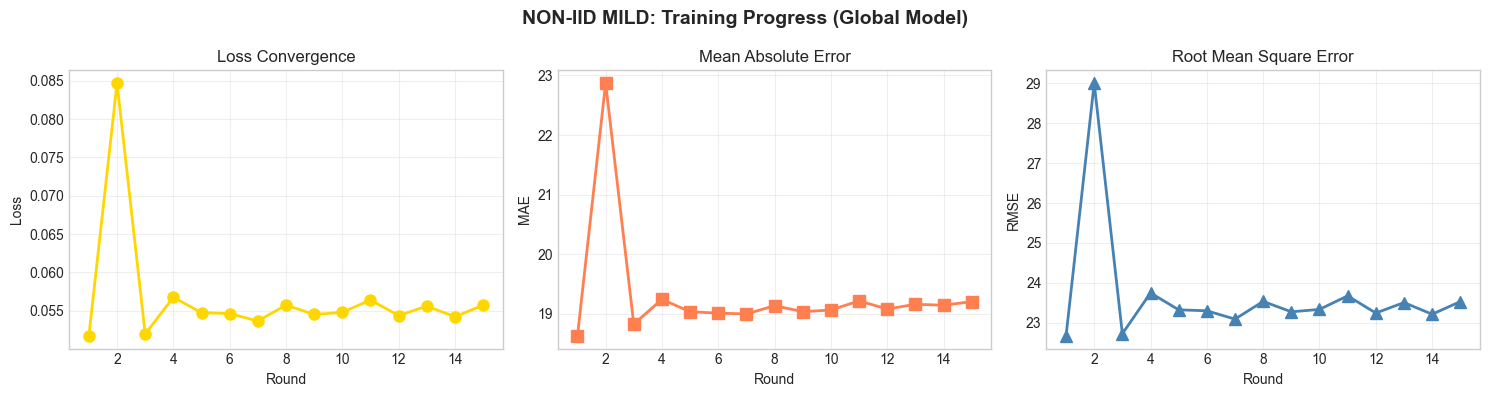


📊 Final Global Model Metrics:
   MAE:  19.21
   RMSE: 23.53
   MSE:  553.57


In [15]:
# Extract metrics from results - use 'round_history' (not 'round_metrics')
round_history = results.get('round_history', [])

if round_history:
    rounds = [r['round_id'] for r in round_history]
    
    # Extract global metrics from each round
    maes = []
    rmses = []
    losses = []
    for r in round_history:
        gm = r.get('global_metrics', {})
        maes.append(gm.get('mae'))
        rmses.append(gm.get('rmse'))
        losses.append(gm.get('loss', gm.get('mse')))
    
    # Plot training progress
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss curve
    valid_losses = [(r, l) for r, l in zip(rounds, losses) if l is not None]
    if valid_losses:
        r_vals, l_vals = zip(*valid_losses)
        axes[0].plot(r_vals, l_vals, 'o-', color='gold', linewidth=2, markersize=8)
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Convergence')
    axes[0].grid(True, alpha=0.3)
    
    # MAE curve
    valid_maes = [(r, m) for r, m in zip(rounds, maes) if m is not None]
    if valid_maes:
        r_vals, m_vals = zip(*valid_maes)
        axes[1].plot(r_vals, m_vals, 's-', color='coral', linewidth=2, markersize=8)
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Mean Absolute Error')
    axes[1].grid(True, alpha=0.3)
    
    # RMSE curve
    valid_rmses = [(r, m) for r, m in zip(rounds, rmses) if m is not None]
    if valid_rmses:
        r_vals, m_vals = zip(*valid_rmses)
        axes[2].plot(r_vals, m_vals, '^-', color='steelblue', linewidth=2, markersize=8)
    axes[2].set_xlabel('Round')
    axes[2].set_ylabel('RMSE')
    axes[2].set_title('Root Mean Square Error')
    axes[2].grid(True, alpha=0.3)
    
    fig.suptitle('NON-IID MILD: Training Progress (Global Model)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_metrics = results.get('final_metrics', {})
    print("\n📊 Final Global Model Metrics:")
    print(f"   MAE:  {final_metrics.get('mae', 'N/A'):.2f}" if final_metrics.get('mae') else "   MAE:  N/A")
    print(f"   RMSE: {final_metrics.get('rmse', 'N/A'):.2f}" if final_metrics.get('rmse') else "   RMSE: N/A")
    print(f"   MSE:  {final_metrics.get('mse', 'N/A'):.2f}" if final_metrics.get('mse') else "   MSE:  N/A")
else:
    print("⚠️ No round history available")

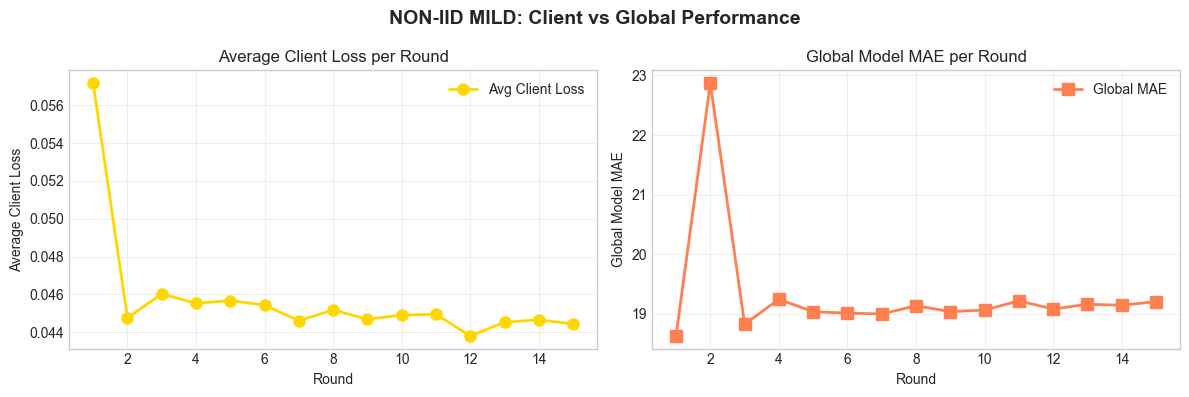


📊 Training Summary:
   Total rounds:        15
   Best round:          1
   Best loss:           0.0517
   Total training time: 199.5s


In [16]:
# Per-round client contribution analysis
# Extract per-round average client metrics from round_history
round_history = results.get('round_history', [])

if round_history:
    # Get per-round average client metrics
    rounds = []
    avg_client_losses = []
    
    for r in round_history:
        rounds.append(r['round_id'])
        avg_cm = r.get('avg_client_metrics', {})
        avg_client_losses.append(avg_cm.get('loss', avg_cm.get('mse', 0)))
    
    # Also get final metrics per round for comparison
    global_metrics_per_round = []
    for r in round_history:
        gm = r.get('global_metrics', {})
        global_metrics_per_round.append(gm.get('mae', 0))
    
    # Plot comparison of client avg vs global model
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Client average losses over rounds
    axes[0].plot(rounds, avg_client_losses, 'o-', color='gold', linewidth=2, markersize=8, label='Avg Client Loss')
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Average Client Loss')
    axes[0].set_title('Average Client Loss per Round')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Global MAE over rounds
    axes[1].plot(rounds, global_metrics_per_round, 's-', color='coral', linewidth=2, markersize=8, label='Global MAE')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('Global Model MAE')
    axes[1].set_title('Global Model MAE per Round')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    fig.suptitle('NON-IID MILD: Client vs Global Performance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print training summary
    print("\n📊 Training Summary:")
    print(f"   Total rounds:        {len(rounds)}")
    print(f"   Best round:          {results.get('best_round', 'N/A')}")
    print(f"   Best loss:           {results.get('best_loss', 'N/A'):.4f}" if results.get('best_loss') else "   Best loss:           N/A")
    print(f"   Total training time: {results.get('total_time', 0):.1f}s")
else:
    print("⚠️ No round history available")

## 6. Summary and Comparison

### Expected Results for Non-IID Mild:

| Metric | Expected vs Clean | Expected vs Hard |
|--------|------------------|------------------|
| Final Loss | Slightly Higher | Lower |
| Convergence Speed | Slightly Slower | Faster |
| Client Variance | Higher | Lower |

The `non_iid_mild` profile should demonstrate:
- Moderate performance degradation from `clean`
- Better performance than `non_iid_hard`
- Reasonable fairness across clients

In [17]:
# Final summary using actual results
final_metrics = results.get('final_metrics', {})
round_history = results.get('round_history', [])

print("="*60)
print("EXPERIMENT SUMMARY: NON-IID MILD BENCHMARK")
print("="*60)
print(f"\n📋 Configuration:")
print(f"   Data Profile:   {config.data_profile}")
print(f"   Algorithm:      {config.algorithm.upper()}")
print(f"   Num Clients:    {config.num_clients}")
print(f"   Num Rounds:     {config.num_rounds}")
print(f"   Local Epochs:   {config.local_epochs}")

print(f"\n📊 Final Results:")
print(f"   MAE:            {final_metrics.get('mae', 'N/A'):.2f}" if final_metrics.get('mae') else "   MAE:            N/A")
print(f"   RMSE:           {final_metrics.get('rmse', 'N/A'):.2f}" if final_metrics.get('rmse') else "   RMSE:           N/A")
print(f"   MSE:            {final_metrics.get('mse', 'N/A'):.2f}" if final_metrics.get('mse') else "   MSE:            N/A")

print(f"\n⏱️ Training Stats:")
print(f"   Best round:     {results.get('best_round', 'N/A')}")
print(f"   Best loss:      {results.get('best_loss', 'N/A'):.4f}" if results.get('best_loss') else "   Best loss:      N/A")
print(f"   Total time:     {results.get('total_time', 0):.1f}s")

# Store results for comparison section
fedavg_mild_results = {
    'mae': final_metrics.get('mae'),
    'rmse': final_metrics.get('rmse'),
    'mse': final_metrics.get('mse'),
    'best_loss': results.get('best_loss'),
    'total_time': results.get('total_time'),
}

print("\n✅ FedAvg on non_iid_mild complete!")

EXPERIMENT SUMMARY: NON-IID MILD BENCHMARK

📋 Configuration:
   Data Profile:   non_iid_mild
   Algorithm:      FEDAVG
   Num Clients:    5
   Num Rounds:     15
   Local Epochs:   3

📊 Final Results:
   MAE:            19.21
   RMSE:           23.53
   MSE:            553.57

⏱️ Training Stats:
   Best round:     1
   Best loss:      0.0517
   Total time:     199.5s

✅ FedAvg on non_iid_mild complete!


## 7. Comprehensive Comparison: Centralized vs Local vs FedAvg vs FedProx

Now we run all four training paradigms on the **same `non_iid_mild` data** for fair comparison:

| Approach | Description |
|----------|-------------|
| **Centralized** | All data pooled together (upper bound) |
| **Local-Only** | Each client trains independently (no collaboration) |
| **FedAvg** | Federated averaging with uniform aggregation |
| **FedProx** | FedAvg + proximal regularization for heterogeneity |

In [20]:
# Run Centralized Baseline on non_iid_mild
# Using the same data generation and manual training loop
from experiments.centralized_baseline import (
    CentralizedConfig, 
    train, 
    prepare_data_loaders,
)
from src.data.non_iid_generator import generate_non_iid_mild_centralized

print("="*60)
print("RUNNING CENTRALIZED BASELINE (non_iid_mild)")
print("="*60)

# Generate centralized data from mild profile
X_cent, y_cent = generate_non_iid_mild_centralized(
    num_clients=5,
    seq_length=100,
    num_channels=14,
    task="rul",
    seed=42,
)
num_channels_cent = X_cent.shape[2]
print(f"Centralized data shape: X={X_cent.shape}, y={y_cent.shape}")

# Configure centralized training
centralized_config = CentralizedConfig(
    data_profile="non_iid_mild",
    task="rul",
    epochs=45,  # 15 rounds * 3 local epochs = 45 total epochs equivalent
    batch_size=32,
    lr=1e-3,
    num_layers=4,
    hidden_dim=64,
    kernel_size=3,
    dropout=0.2,
    fc_hidden=32,
    seed=42,
    deterministic=True,
    output_dir="experiments/outputs/centralized_mild",
    checkpoint_every=0,  # Disable checkpoints
    early_stopping_patience=10,
)

# Prepare data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(X_cent, y_cent, centralized_config)

# Run training
import time
start_time = time.time()
centralized_results = train(centralized_config, train_loader, val_loader, test_loader, num_channels_cent)
centralized_time = time.time() - start_time

centralized_mild_results = {
    'mae': centralized_results.get('test_metrics', {}).get('mae'),
    'rmse': centralized_results.get('test_metrics', {}).get('rmse'),
    'mse': centralized_results.get('test_metrics', {}).get('mse'),
    'total_time': centralized_time,
}
print(f"\n✅ Centralized complete - MAE: {centralized_mild_results['mae']:.2f}, RMSE: {centralized_mild_results['rmse']:.2f}")

RUNNING CENTRALIZED BASELINE (non_iid_mild)


2026-01-17 20:48:52,655 [INFO] Starting centralized training for rul task
2026-01-17 20:48:52,656 [INFO] Model parameters: 93,313
2026-01-17 20:48:52,657 [INFO] Training samples: 910
2026-01-17 20:48:52,658 [INFO] Validation samples: 260
2026-01-17 20:48:52,661 [INFO] Test samples: 130
2026-01-17 20:48:52,663 [INFO] Device: cpu


Centralized data shape: X=(1300, 100, 14), y=(1300,)


2026-01-17 20:48:55,959 [INFO] Epoch   1 | Train Loss: 1894.1241 | Val Loss: 1408.0181 | LR: 1.00e-03 | Time: 3.30s
2026-01-17 20:48:55,960 [INFO]   Train Metrics: mae=37.3705, rmse=43.5215, score=67251.4219
2026-01-17 20:48:55,961 [INFO]   Val Metrics:   mae=31.3907, rmse=37.5236, score=9322.2480
2026-01-17 20:48:59,379 [INFO] Epoch   2 | Train Loss: 989.9088 | Val Loss: 692.1798 | LR: 1.00e-03 | Time: 3.39s
2026-01-17 20:48:59,380 [INFO]   Train Metrics: mae=25.4289, rmse=31.4628, score=21060.4453
2026-01-17 20:48:59,382 [INFO]   Val Metrics:   mae=21.8379, rmse=26.3093, score=2785.5027
2026-01-17 20:49:02,812 [INFO] Epoch   3 | Train Loss: 599.0540 | Val Loss: 558.6305 | LR: 1.00e-03 | Time: 3.41s
2026-01-17 20:49:02,814 [INFO]   Train Metrics: mae=20.1647, rmse=24.4756, score=10424.4229
2026-01-17 20:49:02,815 [INFO]   Val Metrics:   mae=20.1243, rmse=23.6354, score=2742.5107
2026-01-17 20:49:06,174 [INFO] Epoch   4 | Train Loss: 564.2492 | Val Loss: 547.7178 | LR: 1.00e-03 | Time:


✅ Centralized complete - MAE: 19.26, RMSE: 22.50


In [25]:
# Run Local-Only Baseline on non_iid_mild
from experiments.local_only_baseline import LocalOnlyConfig, LocalOnlyBaseline

print("="*60)
print("RUNNING LOCAL-ONLY BASELINE (non_iid_mild)")
print("="*60)

local_config = LocalOnlyConfig(
    data_profile="non_iid_mild",
    num_clients=5,
    task="rul",
    local_epochs=45,  # Same total epochs as centralized
    batch_size=32,
    lr=1e-3,
    num_layers=4,
    hidden_dim=64,
    kernel_size=3,
    dropout=0.2,
    fc_hidden=32,
    seed=42,
    deterministic=True,
    output_dir="experiments/outputs/local_only_mild",
    save_client_models=False,
    compare_centralized=False,
)

local_exp = LocalOnlyBaseline(local_config)
local_results = local_exp.run()

# Extract from results - the structure uses 'global_metrics' with 'mean' and 'std' 
global_metrics = local_results.get('global_metrics', {})
local_mild_results = {
    'mae': global_metrics.get('mae', {}).get('mean'),
    'rmse': global_metrics.get('rmse', {}).get('mean'),
    'mae_std': global_metrics.get('mae', {}).get('std'),
    'total_time': local_results.get('total_train_time'),
}

if local_mild_results['mae']:
    print(f"\n✅ Local-Only complete - Avg MAE: {local_mild_results['mae']:.2f} ± {local_mild_results['mae_std']:.2f}")
else:
    print(f"\n✅ Local-Only complete")

2026-01-17 20:55:58,491 [INFO] ============================================================
2026-01-17 20:55:58,492 [INFO] Local-Only Baseline Experiment
2026-01-17 20:55:58,495 [INFO] ============================================================
2026-01-17 20:55:58,497 [INFO] Configuration: {'data_profile': 'non_iid_mild', 'data_dir': 'data/raw', 'data_files': [], 'window_size': 50, 'hop_size': 10, 'normalize_windows': True, 'global_test_split': 0.15, 'num_clients': 5, 'heterogeneity_mode': 'uniform', 'dirichlet_alpha': 0.5, 'extreme_imbalance': [0.9, 0.7, 0.5, 0.3, 0.1], 'task': 'rul', 'num_classes': 2, 'num_layers': 4, 'hidden_dim': 64, 'kernel_size': 3, 'dropout': 0.2, 'fc_hidden': 32, 'local_epochs': 45, 'batch_size': 32, 'lr': 0.001, 'weight_decay': 0.0001, 'optimizer': 'adam', 'early_stopping_patience': 5, 'early_stopping_min_delta': 0.0001, 'normalize_rul': True, 'rul_max': None, 'seed': 42, 'deterministic': True, 'output_dir': 'experiments/outputs/local_only_mild', 'save_client

2026-01-17 20:55:58,499 [INFO]   - Label skew: overlapping RUL distributions
2026-01-17 20:55:58,500 [INFO]   - Feature skew: moderate noise/bias
2026-01-17 20:55:58,501 [INFO]   - Quantity skew: moderate imbalance


RUNNING LOCAL-ONLY BASELINE (non_iid_mild)


2026-01-17 20:55:58,988 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 20:55:58,995 [INFO] Training data: 1105 samples
2026-01-17 20:55:58,997 [INFO] Global test data: 195 samples
2026-01-17 20:55:58,997 [INFO] 
Client data distribution (non_iid_mild):
2026-01-17 20:55:58,998 [INFO]   Client 0: 340 samples, RUL range: [0.5, 69.5]
2026-01-17 20:55:58,999 [INFO]   Client 1: 255 samples, RUL range: [20.7, 90.0]
2026-01-17 20:55:59,000 [INFO]   Client 2: 212 samples, RUL range: [10.4, 78.8]
2026-01-17 20:55:59,002 [INFO]   Client 3: 170 samples, RUL range: [1.3, 99.0]
2026-01-17 20:55:59,002 [INFO]   Client 4: 127 samples, RUL range: [30.3, 99.7]
2026-01-17 20:55:59,005 [INFO] Training client 0 with 272 samples...
2026-01-17 20:56:27,201 [INFO] Training client 1 with 204 samples...
2026-01-17 20:56:32,597 [INFO] Training client 2 with 170 samples...
2026-01-17 20:56:35,170 [INFO] Training client 3 with 136 samples...
2026-01-17 20:56:39,973 [INFO] Training client 4 with 102 samples...


✅ Local-Only complete - Avg MAE: 20.83 ± 2.63


In [23]:
# Run FedProx on non_iid_mild
print("="*60)
print("RUNNING FEDPROX (non_iid_mild)")
print("="*60)

fedprox_config = FederatedExperimentConfig(
    data_profile="non_iid_mild",
    algorithm="fedprox",  # <-- Key difference from FedAvg
    fedprox_mu=0.01,      # Proximal regularization coefficient
    experiment_id="non_iid_mild_fedprox",
    experiment_name="FL Non-IID Mild FedProx",
    num_clients=5,
    heterogeneity_mode="uniform",
    task="rul",
    num_rounds=15,
    participation_fraction=1.0,
    local_epochs=3,
    batch_size=32,
    lr=1e-3,
    num_layers=4,
    hidden_dim=64,
    kernel_size=3,
    dropout=0.2,
    fc_hidden=32,
    eval_every=1,
    seed=42,
    deterministic=True,
    output_dir="experiments/outputs/fedprox_mild",
    save_checkpoints=False,
)

fedprox_exp = FederatedExperiment(fedprox_config)
fedprox_results = fedprox_exp.run()

fedprox_final = fedprox_results.get('final_metrics', {})
fedprox_mild_results = {
    'mae': fedprox_final.get('mae'),
    'rmse': fedprox_final.get('rmse'),
    'mse': fedprox_final.get('mse'),
    'best_loss': fedprox_results.get('best_loss'),
    'total_time': fedprox_results.get('total_time'),
}
print(f"\n✅ FedProx complete - MAE: {fedprox_mild_results['mae']:.2f}")

2026-01-17 20:52:19,897 [INFO] Using NON-IID MILD data profile
2026-01-17 20:52:19,899 [INFO]   - Label skew: overlapping RUL distributions
2026-01-17 20:52:19,901 [INFO]   - Feature skew: moderate noise/bias
2026-01-17 20:52:19,903 [INFO]   - Quantity skew: moderate imbalance


RUNNING FEDPROX (non_iid_mild)


2026-01-17 20:52:20,477 [INFO] Total data shape: (1300, 100, 14)
2026-01-17 20:52:20,488 [INFO] Partitioned data across 5 clients (non_iid_mild)
2026-01-17 20:52:20,490 [INFO]   Client 0: 340 samples, RUL: [0.5, 69.5]
2026-01-17 20:52:20,492 [INFO]   Client 1: 255 samples, RUL: [20.7, 90.0]
2026-01-17 20:52:20,495 [INFO]   Client 2: 212 samples, RUL: [10.4, 78.8]
2026-01-17 20:52:20,498 [INFO]   Client 3: 170 samples, RUL: [1.3, 99.0]
2026-01-17 20:52:20,499 [INFO]   Client 4: 127 samples, RUL: [30.3, 99.7]
2026-01-17 20:52:20,508 [INFO] ============================================================
2026-01-17 20:52:20,509 [INFO] Starting Federated Training: non_iid_mild_fedprox
2026-01-17 20:52:20,510 [INFO]   Algorithm: FEDPROX
2026-01-17 20:52:20,511 [INFO]   FedProx mu: 0.01
2026-01-17 20:52:20,512 [INFO]   Rounds: 15
2026-01-17 20:52:20,513 [INFO]   Clients: 5
2026-01-17 20:52:20,515 [INFO]   Participation: 100%
2026-01-17 20:52:20,516 [INFO]   Local epochs: 3
2026-01-17 20:52:20,51


✅ FedProx complete - MAE: 19.26


COMPREHENSIVE COMPARISON: NON-IID MILD DATA

📊 Performance Comparison Table:
        Approach       MAE      RMSE   Time (s)
     Centralized 19.263416 22.504858  66.030643
Local-Only (Avg) 20.825337 25.264664  42.802490
          FedAvg 19.206926 23.527980 199.513495
         FedProx 19.259512 23.023848 168.177917


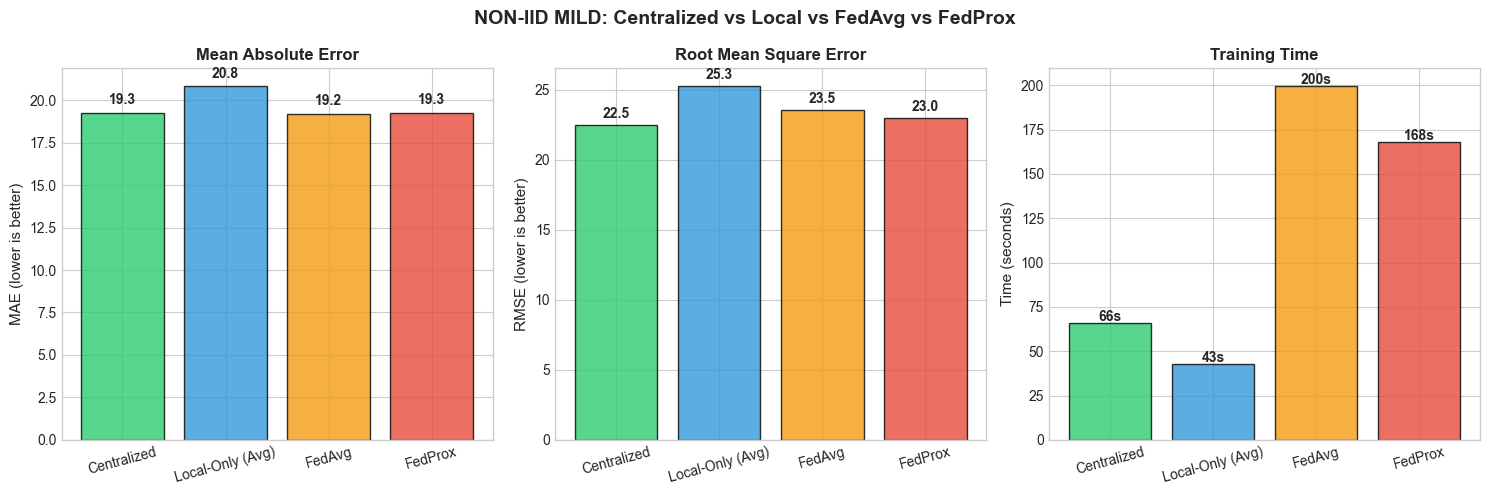

In [26]:
# Comprehensive Comparison Table and Visualization
print("="*60)
print("COMPREHENSIVE COMPARISON: NON-IID MILD DATA")
print("="*60)

# Build comparison dataframe
comparison_data = {
    'Approach': ['Centralized', 'Local-Only (Avg)', 'FedAvg', 'FedProx'],
    'MAE': [
        centralized_mild_results.get('mae'),
        local_mild_results.get('mae'),
        fedavg_mild_results.get('mae'),
        fedprox_mild_results.get('mae'),
    ],
    'RMSE': [
        centralized_mild_results.get('rmse'),
        local_mild_results.get('rmse'),
        fedavg_mild_results.get('rmse'),
        fedprox_mild_results.get('rmse'),
    ],
    'Time (s)': [
        centralized_mild_results.get('total_time'),
        local_mild_results.get('total_time'),
        fedavg_mild_results.get('total_time'),
        fedprox_mild_results.get('total_time'),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Performance Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']  # Green, Blue, Orange, Red
approaches = comparison_df['Approach'].tolist()

# MAE comparison
mae_values = [v if v is not None else 0 for v in comparison_df['MAE']]
bars1 = axes[0].bar(approaches, mae_values, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('MAE (lower is better)', fontsize=11)
axes[0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
for bar, val in zip(bars1, mae_values):
    if val > 0:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{val:.1f}', ha='center', fontweight='bold')

# RMSE comparison
rmse_values = [v if v is not None else 0 for v in comparison_df['RMSE']]
bars2 = axes[1].bar(approaches, rmse_values, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('RMSE (lower is better)', fontsize=11)
axes[1].set_title('Root Mean Square Error', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
for bar, val in zip(bars2, rmse_values):
    if val > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.1f}', ha='center', fontweight='bold')

# Time comparison
time_values = [v if v is not None else 0 for v in comparison_df['Time (s)']]
bars3 = axes[2].bar(approaches, time_values, color=colors, edgecolor='black', alpha=0.8)
axes[2].set_ylabel('Time (seconds)', fontsize=11)
axes[2].set_title('Training Time', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)
for bar, val in zip(bars3, time_values):
    if val > 0:
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{val:.0f}s', ha='center', fontweight='bold')

fig.suptitle('NON-IID MILD: Centralized vs Local vs FedAvg vs FedProx', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Final Summary & Key Findings

### Expected Observations for Non-IID Mild:

| Approach | Expected Performance |
|----------|---------------------|
| **Centralized** | Best performance (upper bound) - all data available |
| **Local-Only** | High variance, moderate average - limited data per client |
| **FedAvg** | Better than local, close to centralized - benefits from collaboration |
| **FedProx** | Similar or slightly better than FedAvg - proximal term helps with heterogeneity |

### Key Insights:
1. **FL vs No-FL**: Federated approaches should outperform local-only training
2. **Heterogeneity Impact**: Mild non-IID shows smaller gap vs centralized than hard non-IID
3. **FedProx Benefit**: Proximal regularization helps stabilize training under heterogeneity

In [27]:
# Final Summary
print("="*70)
print("NOTEBOOK 09 COMPLETE: NON-IID MILD COMPREHENSIVE EVALUATION")
print("="*70)

print("\n📊 Results Summary:")
print("-"*70)
print(f"{'Approach':<20} {'MAE':>10} {'RMSE':>10} {'Time (s)':>12}")
print("-"*70)
print(f"{'Centralized':<20} {centralized_mild_results.get('mae', 0):>10.2f} {centralized_mild_results.get('rmse', 0):>10.2f} {centralized_mild_results.get('total_time', 0):>12.1f}")
print(f"{'Local-Only (Avg)':<20} {local_mild_results.get('mae', 0):>10.2f} {local_mild_results.get('rmse', 0):>10.2f} {local_mild_results.get('total_time', 0):>12.1f}")
print(f"{'FedAvg':<20} {fedavg_mild_results.get('mae', 0):>10.2f} {fedavg_mild_results.get('rmse', 0):>10.2f} {fedavg_mild_results.get('total_time', 0):>12.1f}")
print(f"{'FedProx':<20} {fedprox_mild_results.get('mae', 0):>10.2f} {fedprox_mild_results.get('rmse', 0):>10.2f} {fedprox_mild_results.get('total_time', 0):>12.1f}")
print("-"*70)

# Calculate relative performance
best_federated_mae = min(fedavg_mild_results.get('mae', float('inf')), fedprox_mild_results.get('mae', float('inf')))
centralized_mae = centralized_mild_results.get('mae', 0)
local_mae = local_mild_results.get('mae', 0)

if centralized_mae and best_federated_mae:
    gap_to_centralized = ((best_federated_mae - centralized_mae) / centralized_mae) * 100
    print(f"\n📈 Performance Gap: Best FL is {gap_to_centralized:+.1f}% vs Centralized")

if local_mae and best_federated_mae:
    improvement_over_local = ((local_mae - best_federated_mae) / local_mae) * 100
    print(f"📈 FL Improvement:  {improvement_over_local:+.1f}% better than Local-Only")

print("\n✅ All experiments completed successfully!")
print("   - Centralized baseline (upper bound)")
print("   - Local-only baseline (no collaboration)")
print("   - FedAvg (standard federated learning)")
print("   - FedProx (heterogeneity-aware FL)")

NOTEBOOK 09 COMPLETE: NON-IID MILD COMPREHENSIVE EVALUATION

📊 Results Summary:
----------------------------------------------------------------------
Approach                    MAE       RMSE     Time (s)
----------------------------------------------------------------------
Centralized               19.26      22.50         66.0
Local-Only (Avg)          20.83      25.26         42.8
FedAvg                    19.21      23.53        199.5
FedProx                   19.26      23.02        168.2
----------------------------------------------------------------------

📈 Performance Gap: Best FL is -0.3% vs Centralized
📈 FL Improvement:  +7.8% better than Local-Only

✅ All experiments completed successfully!
   - Centralized baseline (upper bound)
   - Local-only baseline (no collaboration)
   - FedAvg (standard federated learning)
   - FedProx (heterogeneity-aware FL)
